In [2]:
import pandas as pd
from os import path
import csv
import numpy as np
from time import time
from scipy.stats import chisquare
import scipy
import matplotlib.pyplot as plt

In [6]:
##1 compute Allele Frequency for the minor allele
def computeAlleleFrequency (f_C, f_T):
    """3
    f_C = minor allele count
    f_T = major allele count
    minor_allele_frequency = f_C/ (f_C+f_T) 
    7"""
    minor_allele_frequency = f_C/(f_C+f_T)
    return minor_allele_frequency

def getAlleleCounts (genotype):
    """ 12
    genotype = "C C 	C T 	C T 	C T 	T T"
    Allele frequency:
    count the "Cs", and the "Ts"
    f_C = # of Cs
    f_T = # of T's
    18"""
    dicto = {}
    stro = genotype.to_string()
    if stro.count('C')!=0:
        dicto.update({'C': stro.count('C')})
    if stro.count('T')!=0:
        dicto.update({'T': stro.count('T')})
    if stro.count('G')!=0:
        dicto.update({'G': stro.count('G')})
    if stro.count('A')!=0:
        dicto.update({'A': stro.count('A')})
    if len(dicto)==1:
        dicto.update({'-1':0})
    return dicto

def getGenotypeCounts (genotype):
    stro = genotype.to_string()
    cc = stro.count('C C')
    tt = stro.count('T T')
    aa = stro.count('A A')
    ag = stro.count('A G')
    gg = stro.count('G G')
    if cc==0 and tt==0:
        return np.array([aa,ag+stro.count('G A'),gg])
    elif gg==0 and tt==0: 
        return np.array([aa,stro.count('A C')+stro.count('C A'),cc])
    elif gg==0 and aa==0: 
        return np.array([cc,stro.count('C T')+stro.count('T C'),tt])
    else:
        return np.array([tt,stro.count('G T')+stro.count('T G'),gg])

#30 # Compute the Odds Ratio
#31 # takes as input a 2X2  confusion matrix
#32 # returns the odds ratio
def computeOR(health,diabetic):
    if health[0] ==0 or diabetic[1]==0:
        return 0
    else:
        return diabetic[0]*health[1]/(health[0]*diabetic[1])

#36 # Execute a chisq test to determine if the odds ratio is significant
#37 # return the p-value from the chisq test

def getPValue(confusionMatrix):
    from scipy.stats import chi2_contingency
    chi2, p, dof, exptected = chi2_contingency(confusionMatrix)
    return p

def get_snp_stats(control, disease):
    
    health_v = list(getAlleleCounts(control).values())
    health_k = list(getAlleleCounts(control))
    diabetic_v = list(getAlleleCounts(disease).values())
    diabetic_k = list(getAlleleCounts(disease))
    
# 59    dis_freq = computeAlleleFrequency(diabetic[0], diabetic[1])
# 60    health_freq =  computeAlleleFrequency(health[0], health[1])

    o_r= computeOR(health_v,diabetic_v) # odds ratio
    
    
    minor_allele_con = health_k[0]
    major_allele_con = health_k[1]
    minor_allele_dis = diabetic_k[0]
    major_allele_dis = diabetic_k[1]

    t1_minor = computeAlleleFrequency(diabetic_v[0], diabetic_v[1])
    t1_major = 1 - t1_minor
    control_minor = computeAlleleFrequency(health_v[0], health_v[1])
    control_major = 1-control_minor
    
    mx = pd.DataFrame({'col1':[diabetic_v[0], health_v[0]], 'col2':[diabetic_v[1],health_v[1]]})
    try:
        p = getPValue(mx)
    except:
        p=1

    if control.to_string().count('C C')!=0 and control.to_string().count('C T')!=0 and control.to_string().count('T T')!=0:
        HWE = HWEChiSq(control_minor, getGenotypeCounts(control))
    else:
        HWE = HWEChiSq(control_minor, getGenotypeCounts(control))
    
    
    result=  pd.DataFrame(np.array([minor_allele_con,major_allele_con,minor_allele_dis,major_allele_dis,control_minor,t1_minor,o_r,p,HWE]))
    return result
    
## function to load the data file
def loadFile (disease, chrom_num):
    ## construct your file name based on the disease and chrom_number
    if chrom_num<10:
        stro = '0'+str(chrom_num)
    else:
        stro = str(chrom_num)
    fileName = 'BWSI_test/'+disease+'/Affx_gt_'+disease+'_Chiamo_'+stro+'.tped.gz'
    dat = pd.read_csv(fileName, compression='gzip', header=None, sep='\t')
    return (dat)

def HWEChiSq (p, populationGenotypeCounts):
    """
        |  CC | CT  | TT |
    BP  | 270 | 957 | 771|
    compute the HWE
      -- p = frequency of the C allele
      -- q = 1-p = frequency of the T allele
      -- if the population genotype is in Hardy Weinberg Equilibrium, we would expect the genotype frequencies to be
          CC = p^2*N 
          CT = 2pq*N 
          TT = q^2*N 
      -- to compute the deviation from HWE
         (observed - expected)^2 / expected
      -- do a chi.squared test to check if the deviation is significant
    """
    total = sum(populationGenotypeCounts)
        
    q = 1-p
    
    observed = populationGenotypeCounts[0]
    expected = p**2*total
    
    CC = (observed-expected)**2/expected
    
    
    observed = populationGenotypeCounts[1]
    expected = 2*p*q*total
    
    CT = (observed-expected)**2/expected
    
    observed = populationGenotypeCounts[2]
    expected = q**2*total
    
    TT = (observed-expected)**2/expected
    
    from scipy.stats import chisquare
    from scipy.stats.distributions import chi2
    return chi2.sf(CC+CT+TT, 1)

In [7]:
bigdf = pd.DataFrame()
snpsid = pd.DataFrame()
for i in range(22):
    
    
    i = i+1
    print("Doing Chromosome "+str(i)+"...")
    t2d = loadFile('T2D',i)
    c1 = loadFile('58C',i)
    
    if i<10:
        stro = '0'+str(i)
    else:
        stro = str(i)
    snp = pd.read_csv('BWSI_100set/58C/snps/snps_'+stro,header=None, sep='\t')
    snp = snp.iloc[:100,:]
    
    t2d_head = t2d.loc[:,0:3]
    t2d_snps = t2d.loc[:,4:]
    c1_head = c1.loc[:,0:3]
    c1_snps = c1.loc[:,4:]
    
    snp = snp.drop([0,1],axis=1)
    snp = snp.rename(columns={3:'snp_name',4:'rs'} )
    
    c1_head = c1_head.rename(columns={1:'snp_name'})
    t2d_head = t2d_head.rename(columns={1:'snp_name'})
    c1_head = c1_head.drop([0,2],axis=1)
    t2d_head = t2d_head.drop([0,2],axis=1)
    
    snp=snp.drop([2],axis=1)
    df = pd.DataFrame()
    #snpsid = snpsid.append(snp)
    joined_con=c1_head.join(snp.set_index('snp_name','rs'), on='snp_name')
    #joined_dis=t2d_head.join(snp.set_index('snp_name','rs'),on='snp_name')
    snpsid = snpsid.append(joined_con)
    
    for j in range(1000):
        t2d_1 = t2d_snps.loc[j,:]
        c1_1 = c1_snps.loc[j,:]
        df=df.append(get_snp_stats(c1_1,t2d_1).transpose())
#         snpsid = snpsid.append(pd.DataFrame(snp.iloc[j,0]))

    bigdf=bigdf.append(df)

Doing Chromosome 1...


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:148: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:148: RuntimeWarning: invalid value encountered in double_scalars


Doing Chromosome 2...
Doing Chromosome 3...
Doing Chromosome 4...
Doing Chromosome 5...
Doing Chromosome 6...
Doing Chromosome 7...
Doing Chromosome 8...
Doing Chromosome 9...
Doing Chromosome 10...
Doing Chromosome 11...
Doing Chromosome 12...
Doing Chromosome 13...
Doing Chromosome 14...
Doing Chromosome 15...
Doing Chromosome 16...
Doing Chromosome 17...
Doing Chromosome 18...
Doing Chromosome 19...
Doing Chromosome 20...
Doing Chromosome 21...
Doing Chromosome 22...


In [8]:
snpsid.reset_index(drop=True, inplace=True)
bigdf.reset_index(drop=True, inplace=True)
a = pd.concat([snpsid,bigdf],axis=1)
a = a.rename(columns={0: 'con min all', 1: "dis min all",2:'con maj all',3:'dis maj all',4:'con maj all freq',5:'dis maj all freq',6:'odds rat',7:'p',8:'HWE'})

In [22]:
a=a.drop(['chr'],axis=1)

In [23]:
arr = np.array([])
for i in range(22):
    i=i+1
    for j in range(1000):
        arr=np.append(arr,i)
chro = pd.DataFrame(arr)
a.insert(0,'chr',chro)
a.to_csv('gene_data1000.csv')

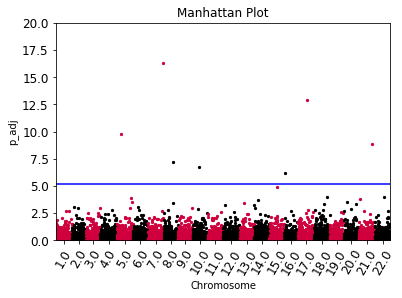

In [26]:
pd.set_option('expand_frame_repr', False)
df = pd.read_csv('gene_data1000.csv')
df= df.iloc[:,1:]
df.head()
    # HWE<0.05
    # allfreq<0.01

df = df[df['HWE']>=0.05]
df = df[df['con maj all freq']>=0.01]
df = df[df['dis maj all freq']>=0.01]


df['p_adj'] = -np.log10(df['p'])
df['chr'] = df['chr'].astype('category')

    # print(df.head(10))

df['ind'] = range(len(df))
df_grouped = df.groupby(('chr'))

    # print(df_grouped.head(10))

fig = plt.figure()
ax = fig.add_subplot(111)
colors = ['#cf003d','#000000']
x_labels = []
x_labels_pos = []
for num, (name, group) in enumerate(df_grouped):
    group.plot(kind='scatter', x='ind', y='p_adj',color=colors[num % len(colors)], ax=ax, s=5)
    x_labels.append(name)
    x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))

ax.set_xticks(x_labels_pos)
ax.set_xticklabels(x_labels)
ax.set_xlim([0, len(df)])
ax.set_ylim([0, 20])
ax.set_xlabel('Chromosome')
plt.xticks(fontsize = 12,rotation=60)
plt.title('Manhattan Plot')
plt.yticks(fontsize = 12)

        # xticks = ax.xaxis.get_major_ticks()
        # xticks[0].set_visible(False)
plt.axhline(y=-np.log10(0.05/len(df)),color='b')
plt.show()

In [27]:
sig_everything = df[df['p_adj']>-np.log10(0.05/len(df))]
len(sig_everything)

7